# **Seminar 3 - Deep Learning tricks**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

**Plan:**
- transfer learning / finetuning
- (?) use additional out-of-task data [+ semi-supervised???]

Learning rate:
- lr schedulers (https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- warmup (https://stackoverflow.com/questions/55933867/what-does-learning-rate-warm-up-mean)


Speed:
- gradient clipping (https://www.quora.com/What-is-gradient-clipping-and-why-is-it-necessary)
- distillation (https://heartbeat.fritz.ai/research-guide-model-distillation-techniques-for-deep-learning-4a100801c0eb)
- quantization (https://leimao.github.io/article/Neural-Networks-Quantization/, https://medium.com/@joel_34050/quantization-in-deep-learning-478417eab72b, https://pytorch.org/blog/introduction-to-quantization-on-pytorch/)

Overfitting:
- label smoothing (https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/)
- temperature (https://www.quora.com/What-is-the-temperature-parameter-in-deep-learning)
- adversarial attack (https://cv-tricks.com/how-to/breaking-deep-learning-with-adversarial-examples-using-tensorflow/, https://towardsdatascience.com/adversarial-examples-in-deep-learning-be0b08a94953, https://wandb.ai/authors/adv-dl/reports/An-Introduction-to-Adversarial-Examples-in-Deep-Learning--VmlldzoyMTQwODM, https://medium.com/@akhilesh.pandey/understanding-adversarial-attacks-on-deep-learning-models-28b071f8cebf)
- learning on adversarial examples (https://medium.com/@akhilesh.pandey/understanding-adversarial-attacks-on-deep-learning-models-28b071f8cebf)
- data + noise (regularization) 



- tensorboard --> look on different metrics

## 1. Подготовка

### 1.1 Скачаем и подготовим данные

sizes:
  train ~ 5000
  test ~ 8000

output:
  images of shape ~ [3, 96, 96]
  classes:
  --airplane
  --bird
  --car
  --cat
  --deer
  --dog
  --horse
  --monkey
  --ship
  --truck


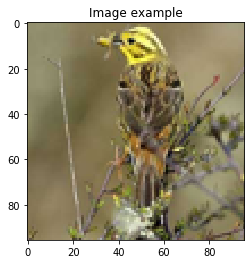

In [435]:
#!g1.2
from torchvision import datasets
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

data = {}

# CIFAR10 ~ smaller, use this one if you want faster performance
# data['train'] = datasets.CIFAR10(root='./data', download=True, train=True)
# data['test'] = datasets.CIFAR10(root='./data', download=True, train=False)

# STL10 ~ bigger, use this one if you want more representitive results
data['train'] = datasets.STL10(root='./data', download=True, split='train')
data['test'] = datasets.STL10(root='./data', download=True, split='test')


clear_output(True)
train_size = len(data['train'])
test_size = len(data['test'])
img = data['train'][0][0]
img_size = [len(img.getbands()), *img.size]
if len(img_size) == 2:
    img_size = [1, *img_size]
classes = data['train'].classes
classes_ = '\n  --'.join(classes)
print(f'sizes:\n  train ~ {train_size}\n  test ~ {test_size}\n' +
      f'\noutput:\n  images of shape ~ {img_size}\n  classes:\n  --{classes_}')

plt.imshow(data['train'][0][0])
plt.title('Image example')
plt.show()

In [452]:
#!g1.2
import numpy as np
from tqdm.notebook import tqdm

channel_mean = np.zeros((img_size[0]))
channel_std = np.zeros((img_size[0]))

for img, _ in tqdm(data['train']):
    img = np.array(img) / 255.
    channel_mean += img.mean(axis=(0, 1))
    channel_std += img.std(axis=(0, 1))

channel_mean /= len(data['train'])
channel_std /= len(data['train'])

print(channel_mean, channel_std)


[0.44671062 0.43980984 0.40664645] [0.22414583 0.22148906 0.22389974]


In [463]:
#!g1.2
class AddTransformsDataset:
    # Class to add custom transforms to any dataset
    def __init__(self, dataset, transforms=None, train=True, val=False):
        self.dataset = dataset
        self.transforms = transforms
        self.val = val
        self.train = train
    
    def __len__(self) -> int:
        if self.train:
            return self.dataset.__len__()
        if not self.val:
            return self.dataset.__len__() // 2
        else:
            return self.dataset.__len__() - (self.dataset.__len__() // 2)
    
    def __getitem__(self, index: int):
        image, label = self.dataset.__getitem__(2 * index + self.val if not self.train else index)
        if self.transforms:
            image = self.transforms(image)
        if len(image.shape) == 2:
            image.unsqueeze_(0)
        return image, label

In [464]:
#!g1.2
from torchvision import transforms as tr
from torch.utils.data import DataLoader


def my_transform():
    return tr.Compose([
        tr.RandomHorizontalFlip(0.5),
        tr.ToTensor(),
        tr.Normalize(channel_mean, channel_std),
    ])


def make_dataloaders(data, batch_size=16, transform_function=None):
    dataloaders = dict()
    
    ds_train = AddTransformsDataset(data['train'], transform_function(), True)
    dataloaders['train'] = DataLoader(
        ds_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    
    ds_test = AddTransformsDataset(data['test'], transform_function(), False, False)
    dataloaders['test'] = DataLoader(
        ds_test,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )
    
    ds_val = AddTransformsDataset(data['test'], transform_function(), False, True)
    dataloaders['val'] = DataLoader(
        ds_val,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )
    
    return dataloaders


dataloaders = make_dataloaders(
    data,
    batch_size=64, # 64 works well for CIFAR10
    transform_function=my_transform
)

print('sizes:')
for split in dataloaders:
    print(f'  {split} ~ {len(dataloaders[split].dataset)}')

sizes:
  train ~ 5000
  test ~ 4000
  val ~ 4000


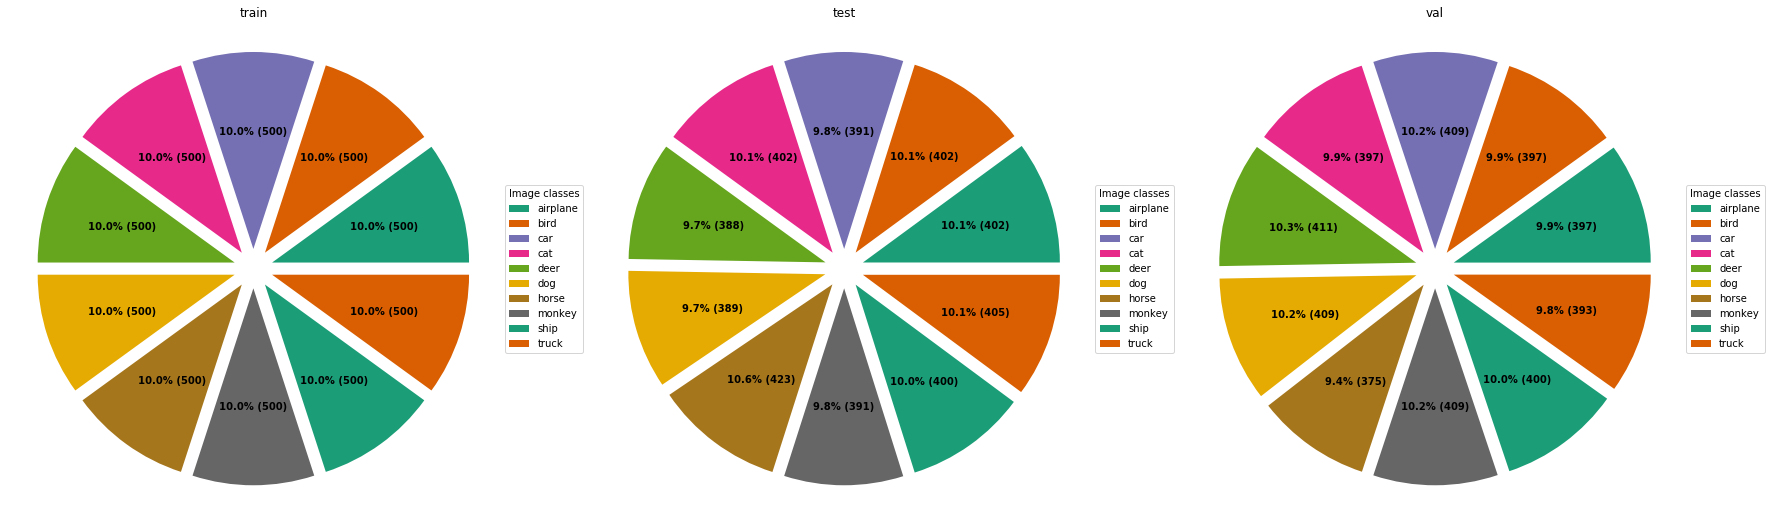

In [465]:
#!g1.2
from collections import Counter

fig, ax = plt.subplots(1, 3, figsize=(30, 20))
for i, split in enumerate(dataloaders):
    plt.subplot(1, 3, i+1)
    plt.title(split)
    size = len(dataloaders[split].dataset)
    cnt = Counter([dataloaders[split].dataset[i][1]
                   for i in range(size)])
    wedges, texts, autotexts = plt.pie(
        [cnt[j] for j in range(len(classes))],
        autopct=lambda pct: '{:.1f}% ({:d})'.format(pct, int(pct/100.*size)),
        textprops=dict(color="black"),
        colors=plt.cm.Dark2.colors,
        startangle=0,
        explode=[0.1]*len(classes)
    )
    plt.legend(wedges, classes, title='Image classes', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=10, weight=700)
plt.show()

### 1.2 Базовая модель

In [483]:
#!g1.2
import numpy as np
import torch
from torch import nn
from collections import OrderedDict


class residual_block(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, activation, dropout_p, pool, i):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            (f'conv', nn.Conv2d(in_c, out_c, kernel_size, padding=(kernel_size-1)//2)),
            (f'bnorm', nn.BatchNorm2d(out_c)),
            (f'act', activation),
            (f'drop', nn.Dropout(dropout_p)),
        ]))
        self.pool = pool
        self.i = i
        if in_c != out_c and self.i:
            self.conv1d = nn.Conv2d(in_c, out_c, 1)
        else:
            self.conv1d = None

    def forward(self, x):
        if self.i:
            return self.pool((x if self.conv1d is None else self.conv1d(x)) + self.block(x))  # Residual connection
        else:
            return self.pool(self.block(x))


class conv_net(nn.Module):
    """
        Simple convolutional network
    """
    def __init__(self, input_size, num_layers, kernel_sizes, hidden_sizes,
                 activations, dropouts, poolings, output_size, use_residual=True):
        super(conv_net, self).__init__()
        
        if not isinstance(kernel_sizes, list):
            kernel_sizes = [kernel_sizes] * num_layers
        assert len(kernel_sizes) == num_layers, f'provide {num_layers} kernel_sizes or just one for all layers'
        
        
#         assert isinstance(hidden_sizes, int), f'provide one hidden_sizes for all layers'
        hidden_sizes = [input_size[0]] + (([hidden_sizes] * num_layers) if isinstance(hidden_sizes, int) else hidden_sizes)
        
        if not isinstance(activations, list):
            activations = [activations] * num_layers
        assert len(activations) == num_layers, f'provide {num_layers} activation functions or just one for all layers'
        
        if not isinstance(dropouts, list):
            dropouts = [dropouts] * num_layers
        assert len(dropouts) == num_layers, f'provide {num_layers} dropout values or just one for all layers'
        
        if not isinstance(poolings, list):
            poolings = [poolings] * num_layers
        assert len(poolings) == num_layers, f'provide {num_layers} poolings or just one for all layers'
        available_poolings = {None, nn.MaxPool2d, nn.AvgPool2d, nn.Identity}
        assert np.sum([poolings[i] in available_poolings for i in range(num_layers)]) == num_layers, \
               f'each pooling should be one of {available_poolings}'
    
        
        self.poolings = [poolings[i](2) if poolings[i] else nn.Identity() for i in range(num_layers)]
        
        if use_residual:
            self.conv_blocks = nn.Sequential(*[residual_block(
                in_c=hidden_sizes[i],
                out_c=hidden_sizes[i+1],
                kernel_size=kernel_sizes[i],
                activation=activations[i],
                dropout_p=dropouts[i],
                pool=self.poolings[i],
                i=i,
            ) for i in range(num_layers)])
        else:
            conv_blocks = [[
                (f'conv_{i+1}', nn.Conv2d(hidden_sizes[i], hidden_sizes[i+1], kernel_sizes[i], padding=(kernel_sizes[i]-1)//2)),
                (f'bnorm_{i+1}', nn.BatchNorm2d(hidden_sizes[i+1])),
                (f'act_{i+1}', activations[i]),
                (f'drop_{i+1}', nn.Dropout(dropouts[i]))
            ] for i in range(num_layers)]
            self.conv_blocks = []
            for block in conv_blocks:
                self.conv_blocks.extend(block)
            self.conv_blocks = nn.Sequential(OrderedDict(self.conv_blocks))
        
        head = [
            ('hid2out', nn.Linear(hidden_sizes[-1], output_size)),
            ('log_softmax', nn.LogSoftmax(dim=-1))
        ]
        self.head = nn.Sequential(OrderedDict(head))
    
    def forward(self, imgs):
        out3d = self.conv_blocks(imgs)
        out1d = torch.amax(out3d, dim=(2, 3))  # Global max pooling
        return self.head(out1d)

In [473]:
#!g1.2
model = conv_net(
    input_size = img_size,
    num_layers = 5,
    kernel_sizes = 5,
    hidden_sizes = [32, 32, 64, 64, 128],
    activations = nn.LeakyReLU(0.2),
    dropouts = 0.2,
    poolings = nn.AvgPool2d,
    output_size = len(classes)
)

print('Model:', model, sep='\n')

imgs_batch, lbls_batch = next(iter(dataloaders['train']))

print(f'\nInput shape: {imgs_batch.shape}')
out = model(imgs_batch)
print(f'Output shape: {out.shape}')

prob_sums = out.exp().sum(-1).detach().numpy()
assert np.allclose(prob_sums, 1), 'all exp-sums must be close to 1, returned not probabilities'

Model:
conv_net(
  (conv_blocks): Sequential(
    (0): residual_block(
      (block): Sequential(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (drop): Dropout(p=0.2, inplace=False)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): residual_block(
      (block): Sequential(
        (conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (drop): Dropout(p=0.2, inplace=False)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): residual_block(
      (block): Sequential(
        (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(

In [474]:
#!g1.2
# Counting how many parameters does our model have
def model_num_params(model, print_=True):
    sum_params = 0
    for param in model.named_parameters():
        num_params = np.prod(param[1].shape)
        if print_:
            print('{: <19} ~  {: <7} params'.format(param[0], num_params))
        sum_params += num_params
    print(f'\nIn total: {sum_params} params')
    return sum_params

sum_params = model_num_params(model)

conv_blocks.0.block.conv.weight ~  2400    params
conv_blocks.0.block.conv.bias ~  32      params
conv_blocks.0.block.bnorm.weight ~  32      params
conv_blocks.0.block.bnorm.bias ~  32      params
conv_blocks.1.block.conv.weight ~  25600   params
conv_blocks.1.block.conv.bias ~  32      params
conv_blocks.1.block.bnorm.weight ~  32      params
conv_blocks.1.block.bnorm.bias ~  32      params
conv_blocks.2.block.conv.weight ~  51200   params
conv_blocks.2.block.conv.bias ~  64      params
conv_blocks.2.block.bnorm.weight ~  64      params
conv_blocks.2.block.bnorm.bias ~  64      params
conv_blocks.2.conv1d.weight ~  2048    params
conv_blocks.2.conv1d.bias ~  64      params
conv_blocks.3.block.conv.weight ~  102400  params
conv_blocks.3.block.conv.bias ~  64      params
conv_blocks.3.block.bnorm.weight ~  64      params
conv_blocks.3.block.bnorm.bias ~  64      params
conv_blocks.4.block.conv.weight ~  204800  params
conv_blocks.4.block.conv.bias ~  128     params
conv_blocks.4.block.

### 1.3 Оптимайзер

In [476]:
#!g1.2
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, beta1=0.9, beta2=0.999, device=device):
    model = model_class(**model_params)
    model = model.to(device)
    
    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
    
    optimizer = torch.optim.Adam(params, lr, [beta1, beta2])
#     optimizer = torch.optim.SGD(params, lr, momentum=0.9)
    return model, optimizer

In [477]:
#!g1.2
model_params = {
    'input_size': img_size,
    'num_layers': 5,
    'kernel_sizes': 5,
    'hidden_sizes': 50,
    'activations': nn.LeakyReLU(0.2),
    'dropouts': 0.2,
    'poolings': nn.MaxPool2d,
    'output_size': len(classes)
}

model, optimizer = create_model_and_optimizer(
    model_class = conv_net, 
    model_params = model_params,
    lr = 1e-3
)

### 1.4 Обучение/валидация на одном шаге

In [478]:
#!g1.2
import torch.nn.functional as F
from tqdm.notebook import tqdm

criterion = nn.NLLLoss()

def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names:
        metrics = {name: [] for name in metric_names}
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            out = model(images)
            loss = criterion(out, targets)
            losses_val.append(loss.item())
            
            if metric_names:
                if 'accuracy' in metrics:
                    _, pred_classes = torch.max(out, dim=-1)
                    metrics['accuracy'].append((pred_classes == targets).float().mean().item())
                if 'top2accuracy' in metrics:
                    preds = torch.argsort(out, dim=1, descending=True)
                    metrics['top2accuracy'].append(
                        np.mean([targets[i] in preds[i, :2] for i in range(len(targets))])
                    )
                if 'top3accuracy' in metrics:
                    preds = torch.argsort(out, dim=1, descending=True)
                    metrics['top3accuracy'].append(
                        np.mean([targets[i] in preds[i, :3] for i in range(len(targets))])
                    )
    
        if metric_names:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

### 1.5 Цикл обучения

In [479]:
#!g1.2
from IPython.display import clear_output
from tqdm.notebook import trange

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, metric_names=None):
    losses = {'train': [], 'val': []}
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names)
            losses['val'].append(loss)
            if metric_names:
                for name in metrics_:
                    metrics[name].append(metrics_[name])
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 2 if metric_names else 1
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            if metric_names:
                plt.subplot(1, ww, 2)
                plt.title('additional metrics')
                for name in metric_names:
                    plt.plot(metrics[name], '.-', label=name)
                plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses, metrics if metric_names else None

### 1.6 Обучаем базовую модель

In [480]:
#!g1.2
models_params = dict()
models = dict()
optimizers = dict()
schedulers = dict()
criterions = dict()
losses = dict()
metrics = dict()

In [481]:
#!g1.2
np.array(img).shape

(96, 96, 3)

In [484]:
#!g1.2
model_type = 'basic'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_params = {
    'input_size': img_size,
    'num_layers': 5,
    'kernel_sizes': 5,
    'hidden_sizes': [32, 32, 64, 64, 128],
#     'activations': nn.Tanh(),
    'activations': nn.LeakyReLU(0.2),
    'dropouts': 0.3,
    'poolings': nn.AvgPool2d,
    'output_size': len(classes),
    'use_residual': True,
}

models[model_type], optimizers[model_type] = create_model_and_optimizer(
    model_class = conv_net, 
    model_params = model_params,
    lr = 1e-3,
    device = device,
)

schedulers[model_type] = None

criterions[model_type] = nn.NLLLoss()

print(models[model_type])
_ = model_num_params(models[model_type], False)

conv_net(
  (conv_blocks): Sequential(
    (0): residual_block(
      (block): Sequential(
        (conv): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (drop): Dropout(p=0.3, inplace=False)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): residual_block(
      (block): Sequential(
        (conv): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.2)
        (drop): Dropout(p=0.3, inplace=False)
      )
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): residual_block(
      (block): Sequential(
        (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bnorm): BatchNorm2d(64, eps

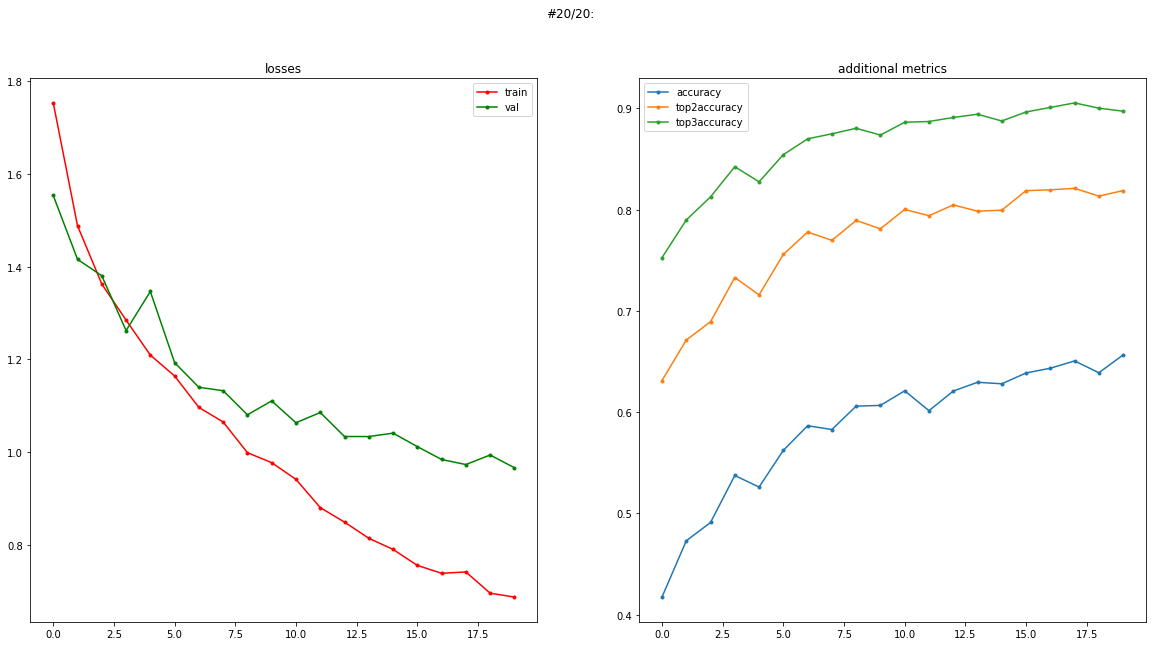

CPU times: user 2min 26s, sys: 6.56 s, total: 2min 33s
Wall time: 2min 30s


In [485]:
#!g1.2
%%time
models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

## 2. Интересные методы над уже обученными моделями

### 2.1 Finetuning

Ситуация: поставлена задача, но данных непосредственно для этой задачи мало, при этом существуют датасеты близкие к данному

Идея: возьмём нейросеть полноценно обученную на схожую задачу и ___дообучим___ модель на наших данных

Предобученные модели для классификации изображений в PyTorch: https://pytorch.org/vision/stable/models.html

In [487]:
#!g1.2
from torchvision import models as mds

model_type = 'resnet_finetune'

models[model_type] = mds.resnet18(pretrained=True)

print(models[model_type])
_ = model_num_params(models[model_type], False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

По сути мы просто обучаемся не со случайного стартового состояния, а с уже обученного состояния

**ОЧЕНЬ ВАЖНО:** Используйте меньший learning rate, чтобы первыми несколькими шагами мы и не сломали бы всю предобработку

In [488]:
#!g1.2
models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-6, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

print(models[model_type])
_ = model_num_params(models[model_type], False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

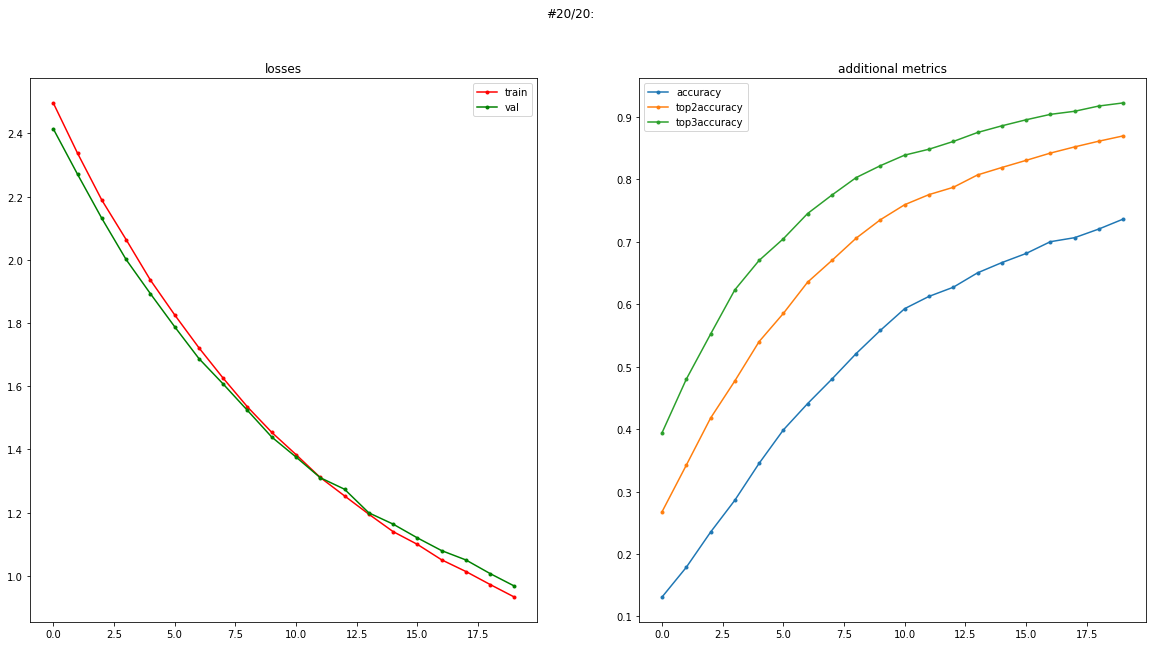

CPU times: user 2min 39s, sys: 7.92 s, total: 2min 47s
Wall time: 2min 44s


In [489]:
#!g1.2
%%time
models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

### 2.2 Transfer learning

Идея очень близкая к finetuning

Главная идея и отличие в том, что здесь мы уже хотим использовать предобученную модель чисто как фича-экстрактор. Мы замораживаем всю модель, кроме головы, а голову заменяем на необходимую нам

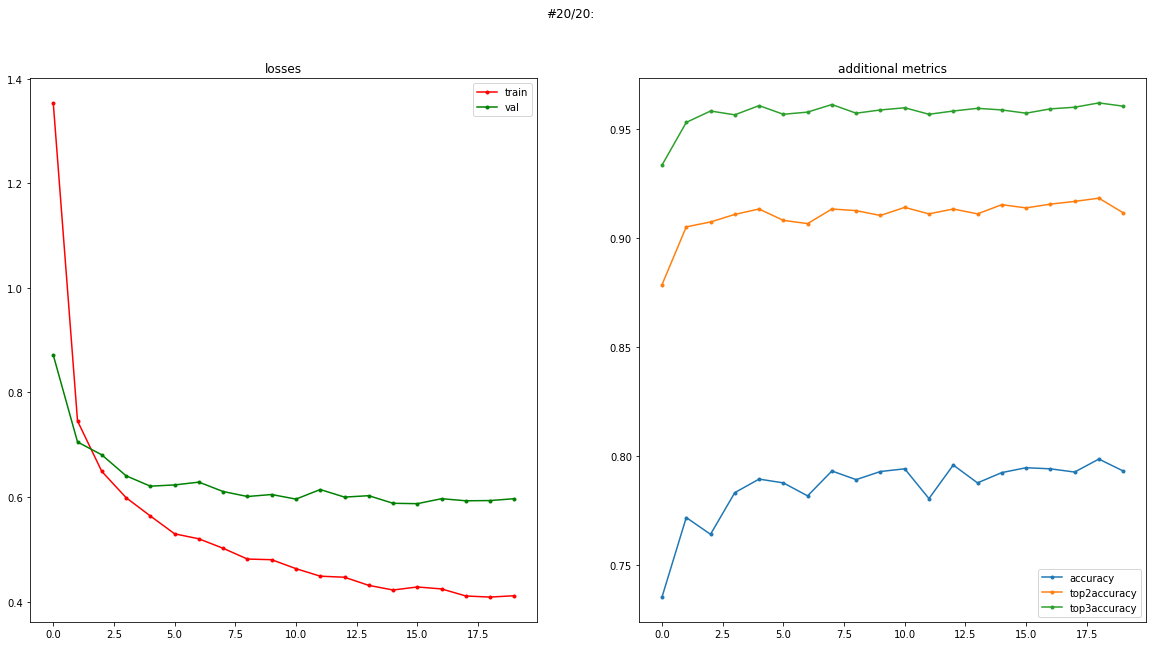

CPU times: user 2min 18s, sys: 4.2 s, total: 2min 22s
Wall time: 2min 19s


In [493]:
#!g1.2
%%time

model_type = 'resnet_transfer'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], metrics[model_type] = learning_loop(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 20,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

## 3. Что можно сделать с lr?

### 3.1 Learning rate schedules

In [494]:
#!g1.2
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop_with_lr(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=10, val_every=1, draw_every=1, metric_names=None):
    losses = {'train': [], 'val': []}
    lrs = []
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names)
            losses['val'].append(loss)
            if metric_names:
                for name in metrics_:
                    metrics[name].append(metrics_[name])
            
            lrs.append(get_lr(optimizer))
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if metric_names else 2
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww, 2)
            plt.title('learning rate')
            plt.plot(lrs, '.-', label='lr')
            plt.legend()
            
            if metric_names:
                plt.subplot(1, ww, 3)
                plt.title('additional metrics')
                for name in metric_names:
                    plt.plot(metrics[name], '.-', label=name)
                plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses, lrs, metrics if metric_names else None

lrs = dict()

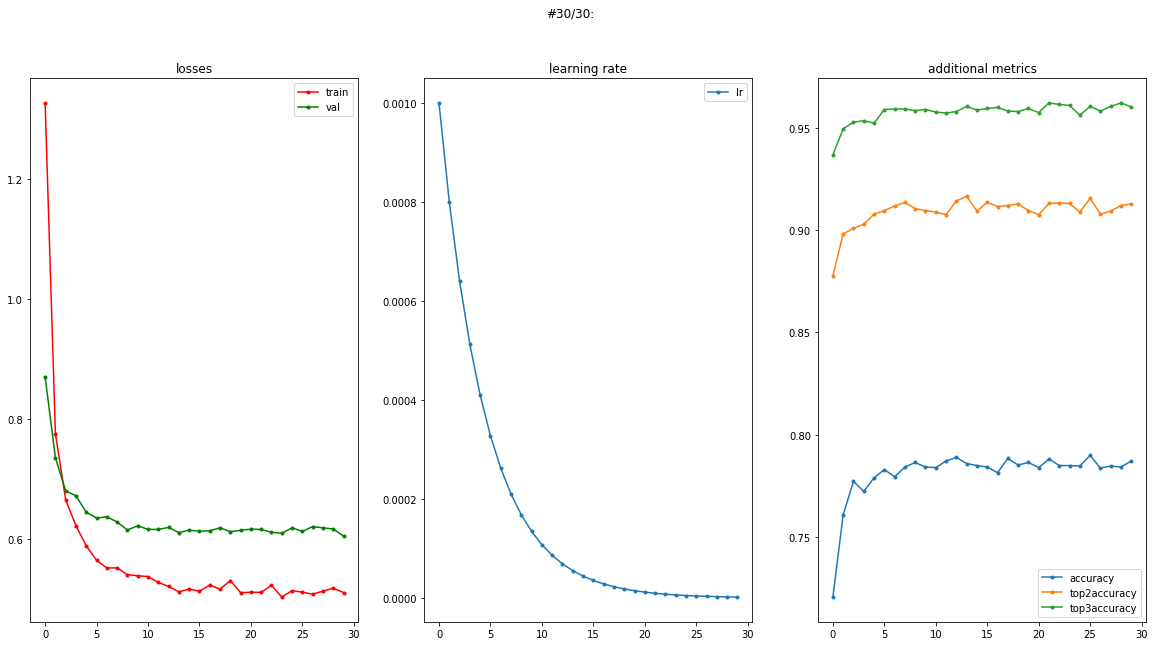

CPU times: user 3min 30s, sys: 6.8 s, total: 3min 37s
Wall time: 3min 33s


In [495]:
#!g1.2
%%time

model_type = 'lr_exponential'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.ExponentialLR(
    optimizers[model_type],
    gamma=0.8,
    verbose=True
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

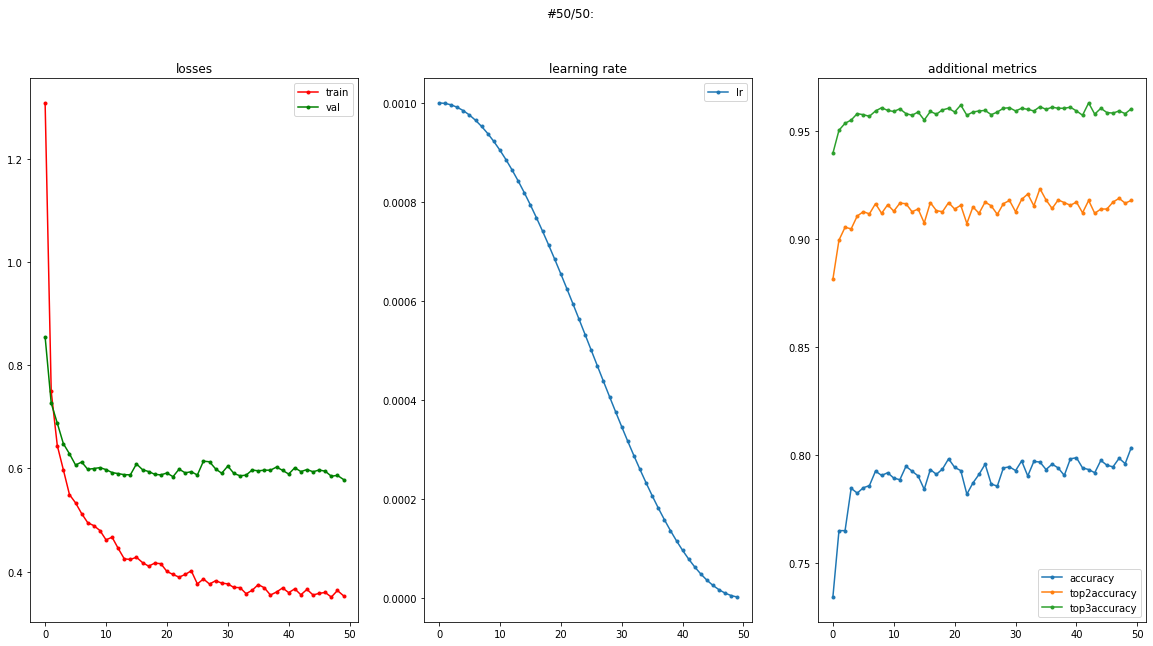

CPU times: user 5min 50s, sys: 10.9 s, total: 6min 1s
Wall time: 5min 54s


In [496]:
#!g1.2
%%time

model_type = 'lr_cosine'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizers[model_type],
    T_max=50,
    verbose=True
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

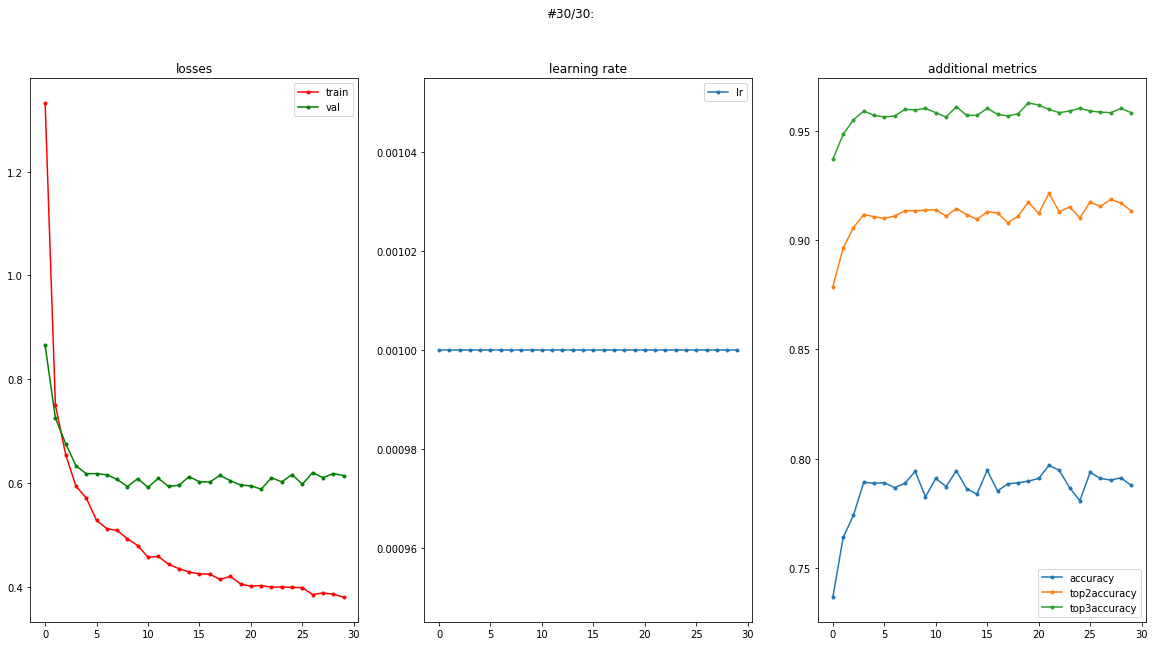

CPU times: user 3min 29s, sys: 6.42 s, total: 3min 36s
Wall time: 3min 32s


In [497]:
#!g1.2
%%time

model_type = 'lr_constant'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

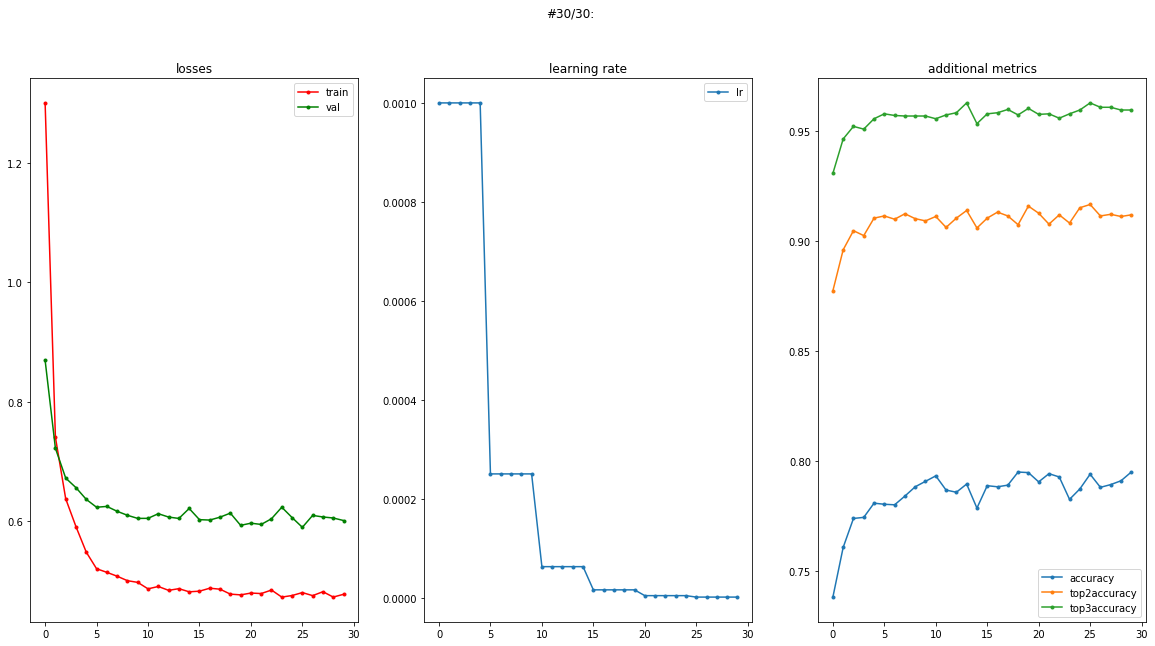

CPU times: user 3min 30s, sys: 6.52 s, total: 3min 37s
Wall time: 3min 33s


In [498]:
#!g1.2
%%time

model_type = 'lr_linear'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.StepLR(
    optimizers[model_type],
    step_size=5,
    gamma=0.25,
    verbose=True
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

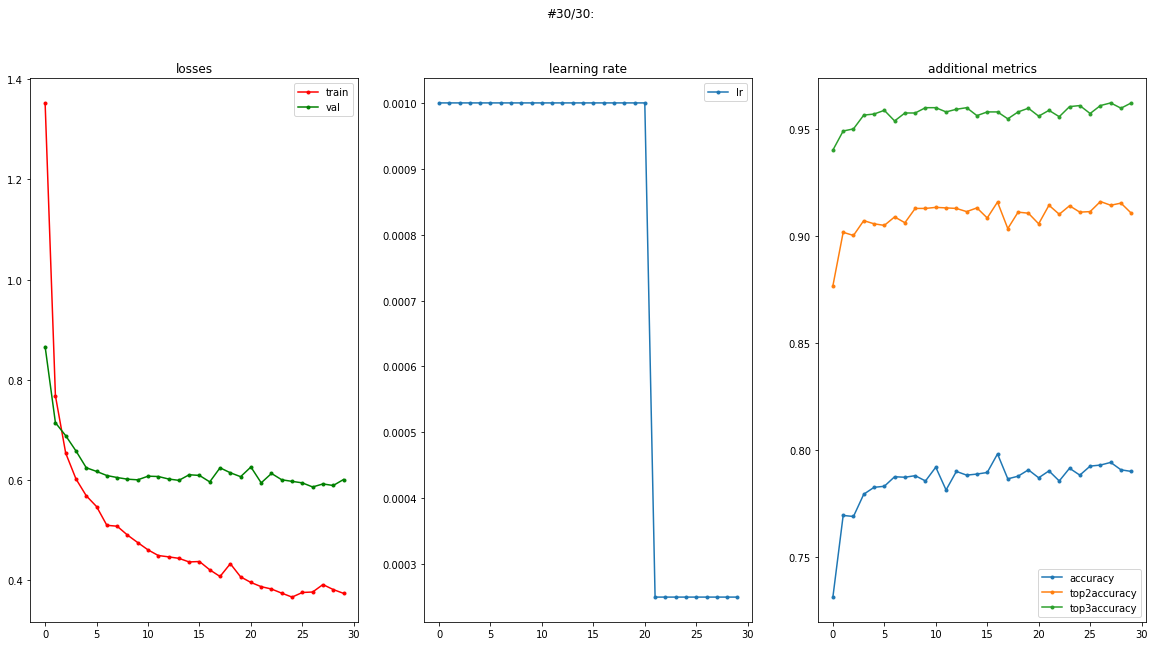

CPU times: user 3min 29s, sys: 6.36 s, total: 3min 36s
Wall time: 3min 32s


In [499]:
#!g1.2
%%time

model_type = 'lr_on_plateau'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizers[model_type],
    mode='min',
    factor=0.25,
    patience=3,
    threshold=1e-4,
    verbose=True,
)

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

**Сравним разные схемы**

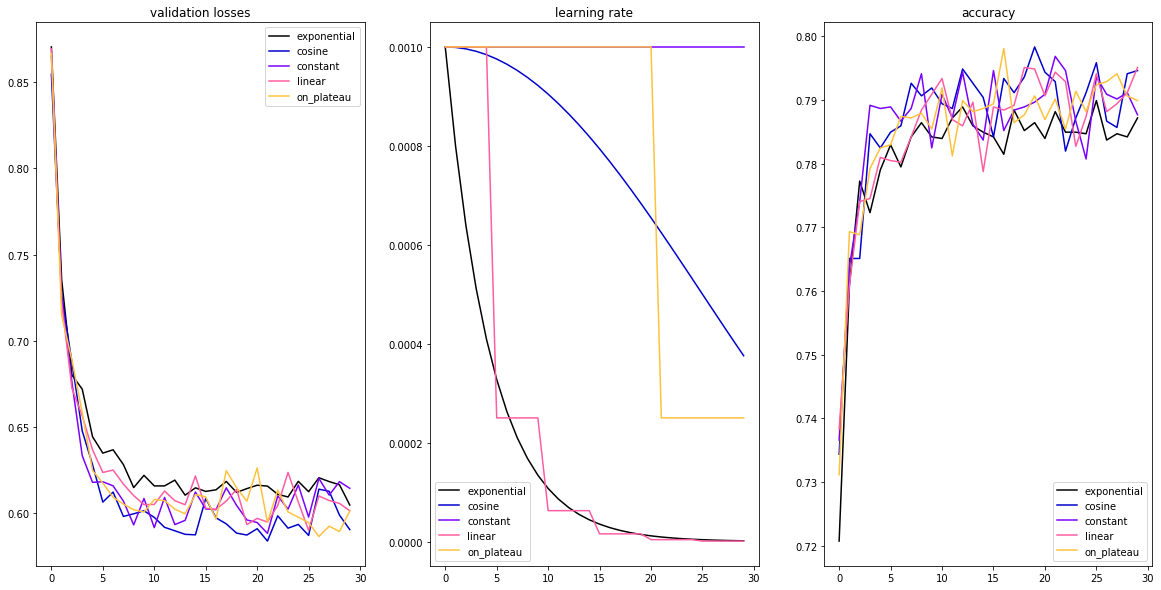

In [501]:
#!g1.2
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

k = 0
for model_type in models:
    if not model_type.startswith('lr'):
        continue
    ax[0].set_title('validation losses')
    ax[0].plot(losses[model_type]['val'][:30], '-', color=colors[k], label=model_type[3:])
    ax[0].legend()
    
    ax[1].set_title('learning rate')
    ax[1].plot(lrs[model_type][:30], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()    
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'][:30], '-', color=colors[k], label=model_type[3:])
    ax[2].legend()
    
    k += 1
plt.show()

### 3.2 Warmup

Позволяет избежать "раннего переобучения", которое может произойти при неудачном батче

In [502]:
#!g1.2
# From https://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer
class WarmupOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, warmup, optimizer):
        self.optimizer = optimizer
        self.param_groups = self.optimizer.param_groups
        self._step = 0
        self.warmup = warmup
        self.model_size = model_size
        self._rate = 0
    
    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}
    
    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict) 
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        self.param_groups = self.optimizer.param_groups
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
    
    def zero_grad(self):
        return self.optimizer.zero_grad()

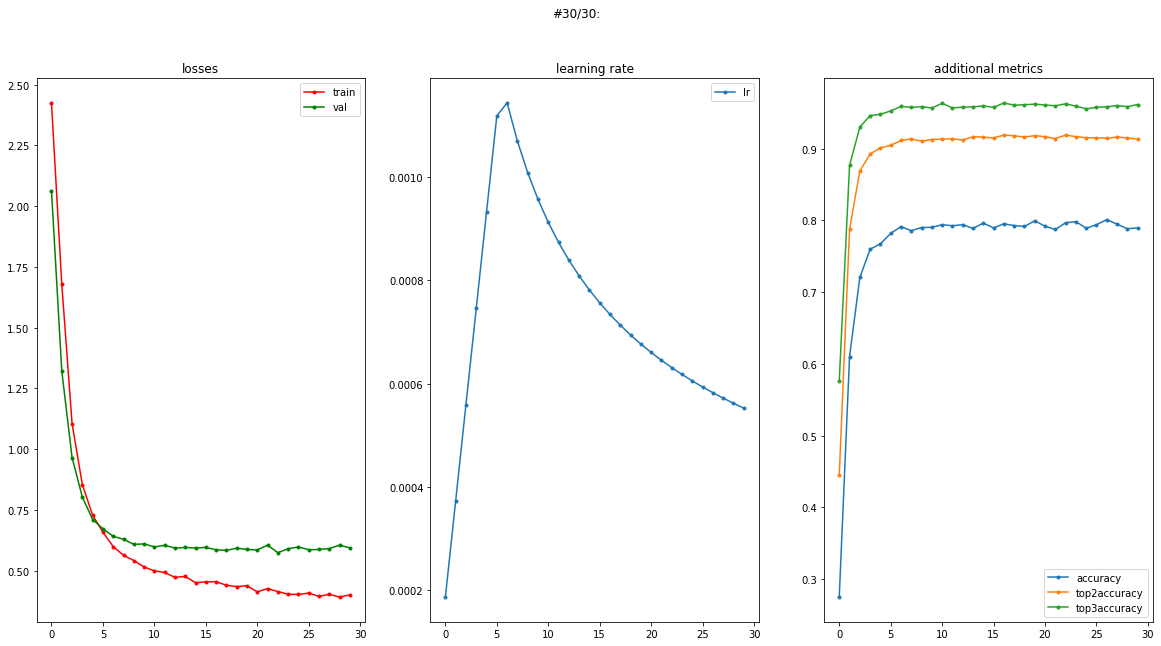

CPU times: user 3min 30s, sys: 6.42 s, total: 3min 37s
Wall time: 3min 33s


In [511]:
#!g1.2
%%time

model_type = 'lr_warmup'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = WarmupOpt(1400, 500, torch.optim.Adam(params, 0, [0.9, 0.999]))

schedulers[model_type] = None

criterions[model_type] = nn.CrossEntropyLoss()

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 30,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

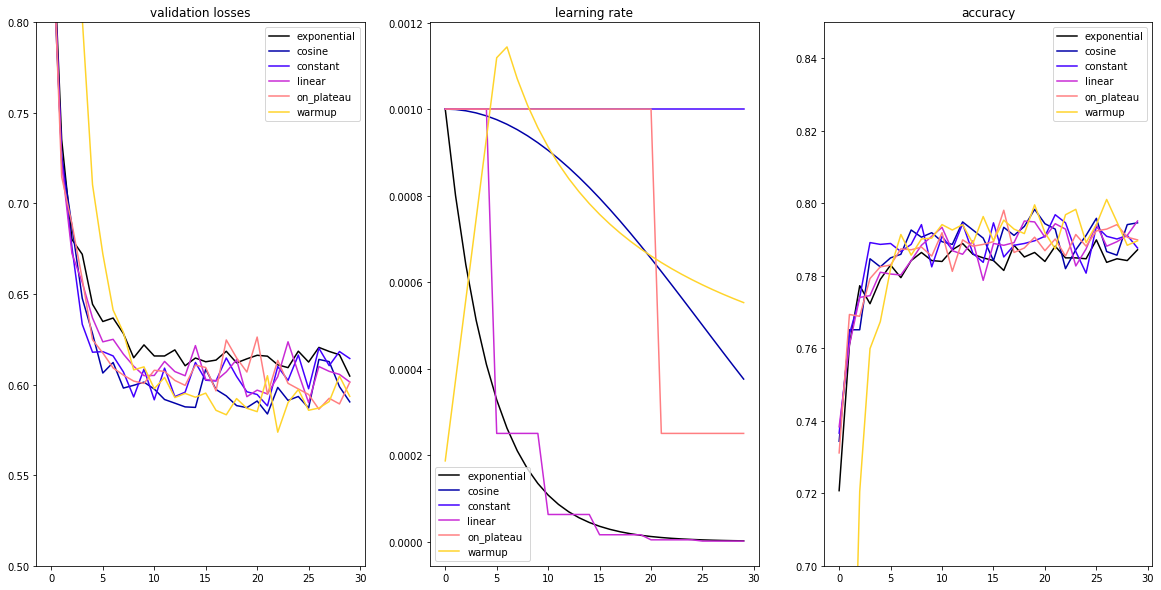

In [513]:
#!g1.2
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]

k = 0
for model_type in models:
    if not model_type.startswith('lr'):
        continue
    ax[0].set_title('validation losses')
    ax[0].set_ylim((0.5, 0.8))
    ax[0].plot(losses[model_type]['val'][:30], '-', color=colors[k], label=model_type[3:])
    
    ax[0].legend()
    
    ax[1].set_title('learning rate')
    ax[1].plot(lrs[model_type][:30], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()    
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'][:30], '-', color=colors[k], label=model_type[3:])
    ax[2].set_ylim((0.7, 0.85))
    ax[2].legend()
    
    k += 1


plt.show()

## 4. Борьба с переобучением

### 4.1 Label smoothing

Хотим ограничить уверенность модели в своих ответах (слишком уверена - риск переобучения)

Простое решение: ослабим таргет лейблы. Пусть теперь это будет не one-hot соответствующего класса, а ослабленный one-hot

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0] --> [0.01, 0.01, 0.01, 0.01, 0.91, 0.01, 0.01, 0.01, 0.01, 0.01]

In [426]:
#!g1.2
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

CPU times: user 4min 17s, sys: 7.73 s, total: 4min 25s
Wall time: 4min 22s


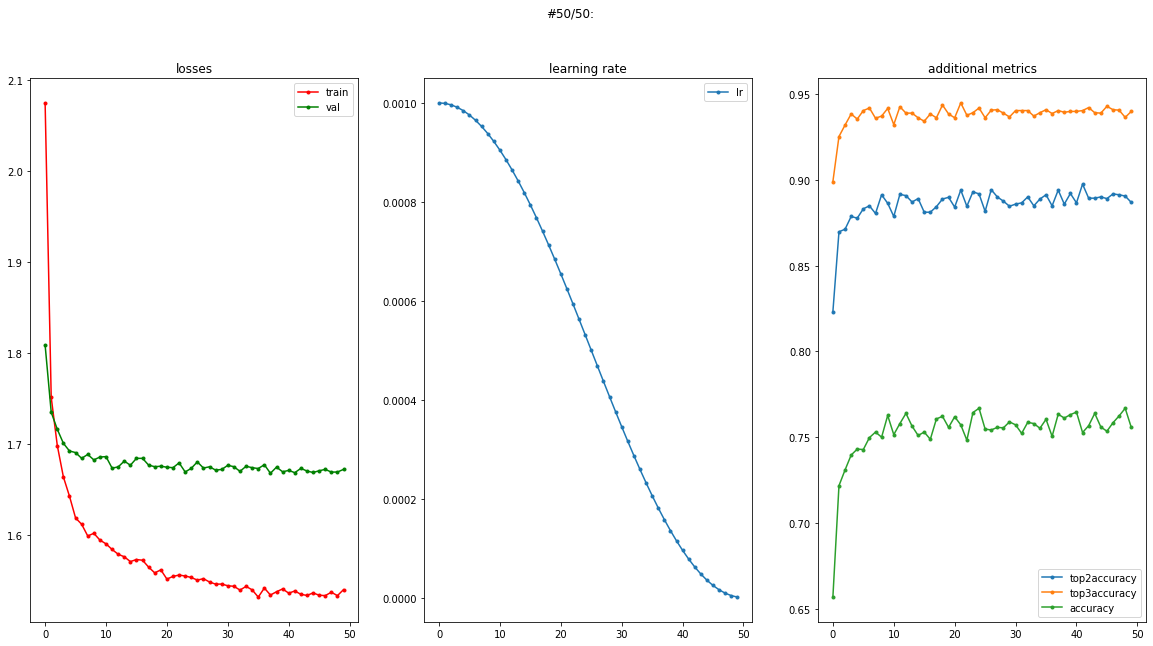

In [430]:
#!g1.2
%%time

model_type = 'label_smooth'

models[model_type] = mds.resnet18(pretrained=True)

for param in models[model_type].parameters():
    param.requires_grad = False  # Freezing all layers

models[model_type].fc = nn.Linear(models[model_type].fc.in_features, len(classes))

models[model_type] = models[model_type].to(device)

params = []
for param in models[model_type].parameters():
    if param.requires_grad:
        params.append(param)

optimizers[model_type] = torch.optim.Adam(params, 1e-3, [0.9, 0.999])

schedulers[model_type] = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizers[model_type],
    T_max=50,
    verbose=True
)

criterions[model_type] = LabelSmoothingCrossEntropy(
    classes = len(classes),
    smoothing = 0.3,
    dim = -1,
    weight = None,
)

models[model_type], optimizers[model_type], losses[model_type], lrs[model_type], metrics[model_type] = learning_loop_with_lr(
    model = models[model_type],
    optimizer = optimizers[model_type],
    train_loader = dataloaders['train'],
    val_loader = dataloaders['val'],
    criterion = criterions[model_type],
    scheduler = schedulers[model_type],
    epochs = 50,
    min_lr = None,
    metric_names = {'accuracy', 'top2accuracy', 'top3accuracy'}
)

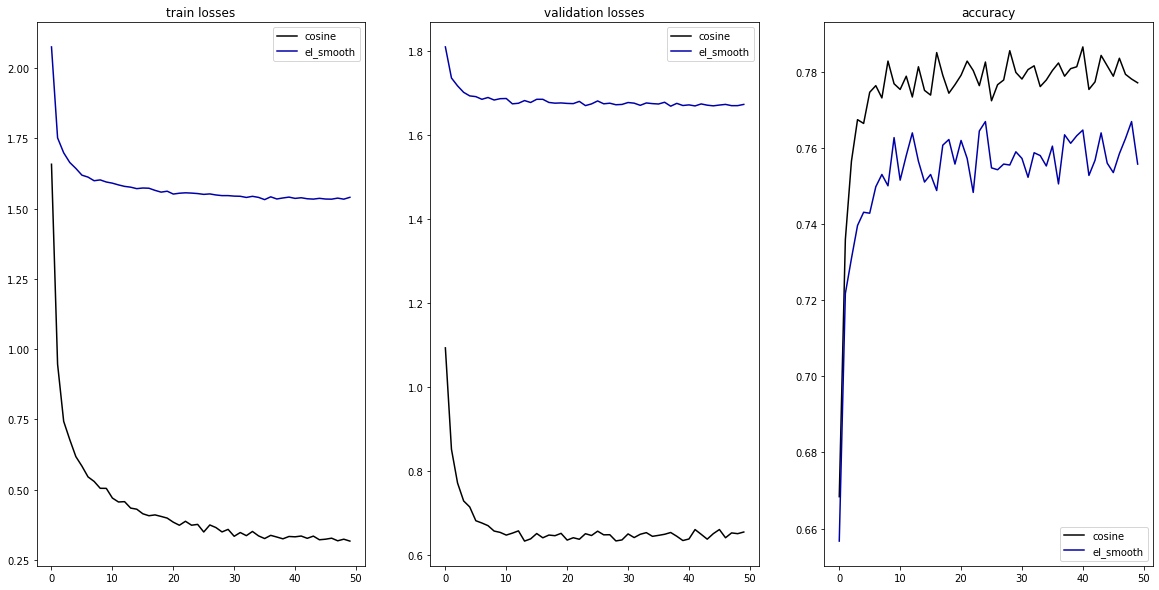

In [433]:
#!g1.2
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

cmap = plt.get_cmap('gnuplot2')
colors = [cmap(i) for i in np.linspace(0, 1, 7)]

k = 0
for model_type in {'lr_cosine', 'label_smooth'}:
    ax[0].set_title('train losses')
    ax[0].plot(losses[model_type]['train'], '-', color=colors[k], label=model_type[3:])
    ax[0].legend()  
    
    ax[1].set_title('validation losses')
    ax[1].plot(losses[model_type]['val'], '-', color=colors[k], label=model_type[3:])
    ax[1].legend()
    
    ax[2].set_title('accuracy')
    ax[2].plot(metrics[model_type]['accuracy'], '-', color=colors[k], label=model_type[3:])
    ax[2].legend()
    
    k += 1
plt.show()

### 4.2 Temperature

$$\text{basic softmax}: \qquad b_i = \frac{\exp(a_i)}{\sum_i \exp(a_i)}$$
$$\text{softmax with temperature}: \qquad b_i = \frac{\exp(\frac{a_i}{t})}{\sum_i \exp(\frac{a_i}{t})}$$

По сути мы делаем то же что делали в label smoothing, но теперь мы это делаем не на уровне правильных ответов, а прямо на уровне предсказаний

А так же t - настраиваемый параметр, обычно хотим начинать с большой температуры и постепенно снижать её

## 5. На поболтать, если останется время

- gradient clipping
- distillation
- quantization
- adversarial attack
- learning on adversarial examples
- data + noise (regularization) 